To tutaj sprawdza proste parametry żeby sprawdzić czy skrypt działa dobrze.
Bardziej skomplikowane siatki wrzucać na kaggla po dopasowaniu i dobraniu danych -
trzeba zmienić nazwe pliku tutaj niżej

In [1]:
def fill_na(df, year_pop_stat, rooms_pop_stat: int, floor_pop_stat: int):

    df['year'] = df['year'].fillna(year_pop_stat)
    df['rooms'] = df['rooms'].fillna(rooms_pop_stat)
    df['floor'] = df['floor'].fillna(floor_pop_stat)

    df['area_outside'] = df['area_outside'].fillna(0)
    df['rent'] = df['rent'].fillna(0)

    df['free_month'] = df['free_month'].fillna(df['upload_month'])
    df['free_year'] = df['free_year'].fillna(df['upload_year'])

    return df

In [ ]:
def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df

In [3]:
from pandas import read_csv
df = read_csv('/kaggle/input/otodomdata/dataset.reduced.bin.csv', index_col=0, low_memory=False)

X = df.drop('price', axis=1)
y = df['price']

from sklearn.model_selection import train_test_split  # żeby uniknąc przecieku mediany
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X = fill_na(X, X['year'].median(), X['rooms'].median(), X['floor'].median())

df = X.merge(y, left_index=True, right_index=True, how='right')
df = remove_outliers(df, 'price')
df = remove_outliers(df, 'year')
df = remove_outliers(df, 'rent')
df = remove_outliers(df, 'area_inside')

y = df['price']
X = df.drop('price', axis=1)

del df

from ydata_profiling import ProfileReport
ProfileReport(X, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
from numpy import array
grid = {
    'max_samples':      array([0.01]),

    'n_estimators':         array([20, 40]),

    'min_samples_split':    array([20, 40]),
    'min_samples_leaf':     array([20, 40]),

    'ccp_alpha': array([0, 0.1, 0.15, 0.30])
}

from itertools import product
print(len(list(product(*grid.values()))))

32


In [5]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

from sklearn.model_selection import GridSearchCV
search = GridSearchCV(model, cv=3, param_grid = grid, verbose=3, scoring='neg_mean_squared_error')
search.fit(X, y)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END ccp_alpha=0.0, max_samples=0.01, min_samples_leaf=20, min_samples_split=20, n_estimators=20;, score=-11098170521.317 total time=   0.5s
[CV 2/3] END ccp_alpha=0.0, max_samples=0.01, min_samples_leaf=20, min_samples_split=20, n_estimators=20;, score=-11026477581.206 total time=   0.5s
[CV 3/3] END ccp_alpha=0.0, max_samples=0.01, min_samples_leaf=20, min_samples_split=20, n_estimators=20;, score=-11185770304.194 total time=   0.5s
[CV 1/3] END ccp_alpha=0.0, max_samples=0.01, min_samples_leaf=20, min_samples_split=20, n_estimators=40;, score=-11087272652.497 total time=   1.0s
[CV 2/3] END ccp_alpha=0.0, max_samples=0.01, min_samples_leaf=20, min_samples_split=20, n_estimators=40;, score=-11059736869.334 total time=   1.0s
[CV 3/3] END ccp_alpha=0.0, max_samples=0.01, min_samples_leaf=20, min_samples_split=20, n_estimators=40;, score=-11092935430.178 total time=   1.0s
[CV 1/3] END ccp_alpha=0.0, max_samples=0.01,

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'ccp_alpha': array([0.  , 0.1 , 0.15, 0.3 ]),
                         'max_samples': array([0.01]),
                         'min_samples_leaf': array([20, 40]),
                         'min_samples_split': array([20, 40]),
                         'n_estimators': array([20, 40])},
             scoring='neg_mean_squared_error', verbose=3)

In [15]:
from pandas import DataFrame
results = DataFrame(search.cv_results_)
results.set_index([*results.filter(like='param_').columns], inplace=True)
results.sort_values(by='mean_test_score', inplace=True, ascending=False)
results = results[['mean_test_score', 'std_test_score', # przesunięcie tych kolumn na początek
    *results.drop(columns=['mean_test_score', 'std_test_score']).columns]]
results.drop('params', axis=1, inplace=True)

results

mean_test_score  \
param_ccp_alpha param_max_samples param_min_samples_leaf param_min_samples_split param_n_estimators                    
0.30            0.01              20                     20                      20                         0.195233   
0.00            0.01              20                     40                      40                         0.195060   
0.30            0.01              20                     40                      40                         0.195000   
0.00            0.01              20                     40                      20                         0.194116   
0.10            0.01              20                     20                      20                         0.193713   
0.00            0.01              20                     20                      20                         0.192788   
0.30            0.01              20                     20                      40                         0.191999   
0.10            0.01              20                     20                      40                         0.190330   
                                                         40                      40                         0.189699   
0.15            0.01              20                     20                      40                         0.187985   
0.00            0.01              40                     20                      40                         0.183169   
0.10            0.01              40                     20                      40                         0.183053   
0.00            0.01              40                     40                      40                         0.182429   
                                                                                 20                         0.182408   
0.10            0.01              40                     40                      40                         0.182295   
0.15            0.01              40                     40                      40                         0.182237   
0.00            0.01              40                     20                      20                         0.182151   
0.30            0.01              40                     40                      20                         0.182090   
0.15            0.01              40                     20                      40                         0.181932   
0.10            0.01              40                     40                      20                         0.181761   
0.30            0.01              40                     40                      40                         0.181704   
0.00            0.01              20                     20                      40                         0.180858   
0.15            0.01              20                     20                      20                         0.178541   
0.30            0.01              40                     20                      40                         0.176567   
0.10            0.01              20                     40                      20                         0.175514   
0.15            0.01              40                     20                      20                         0.173668   
0.30            0.01              40                     20                      20                         0.173241   
0.10            0.01              40                     20                      20                         0.172976   
0.15            0.01              20                     40                      40                         0.171634   
0.30            0.01              20                     40                      20                         0.159270   
0.15            0.01              40                     40                      20                         0.156435   
                                  20                     40                      20                         0.145537   

                    

In [16]:
results.reset_index(inplace=True)
results.rename(columns=lambda x: x.replace('param_', ''), inplace=True)

from plotly.graph_objects import Figure, Scatter3d

def scatter_3d(df, 
               x_col, y_col, z_col, size_col, color_col, 
               x_title, y_title, z_title, size_title, color_title, 
               color_scale=[0,1], scatter=0.01):

    from numpy import random, log, mean

    fig = Figure(data=[Scatter3d(
        x=df[x_col] + mean(df[x_col]) * random.normal(0, scatter, size=len(df)),
        y=df[y_col] + mean(df[y_col]) * random.normal(0, scatter, size=len(df)),
        z=df[z_col] + mean(df[z_col]) * random.normal(0, scatter, size=len(df)),
        mode='markers',
        marker=dict(
            size=log(df[size_col])*2+1,
            sizemode='diameter',
            opacity=0.8,
            color=df[color_col],
            colorscale='thermal',
            colorbar=dict(title=color_title),
            cmin=color_scale[0] if color_scale else None,
            cmax=color_scale[1] if color_scale else None
        ),
        text=
            x_title + '=' + df[x_col].astype(str) + '; ' + 
            y_title + '=' + df[y_col].astype(str) + '; ' + 
            z_title + '=' + df[z_col].astype(str) + '; ' +
            size_title + '='+ df[size_col].astype(str) + '; ' + 
            color_title + '='+ round(df[color_col],3).astype(str),
        hoverinfo='text'
    )])

    fig.update_layout(
        title="Parametry i wyniki walidacji krzyżowej",
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title=x_title,
            yaxis_title=y_title,
            zaxis_title=z_title
        )
    )
    
    return fig

def scatter_3d_params(df, scatter=0.01, color_scale=[0,1]):

    return scatter_3d(df, 
        'min_samples_leaf', 'min_samples_split', 'ccp_alpha', 'n_estimators', 'mean_test_score', 
        'Min.L', 'Min.S', 'A', 'ne', 'score', scatter = 0.01, color_scale=color_scale
    )

scatter_3d_params(results, color_scale=None)

In [17]:
best = RandomForestRegressor(**search.best_params_)
best.fit(X, y)
DataFrame(search.best_params_, index=[search.best_score_])

,ccp_alpha,max_samples,min_samples_leaf,min_samples_split,n_estimators
0.195233,0.3,0.01,20,20,20


In [18]:
from pandas import DataFrame
from numpy import array

X_test = fill_na(X_test, X['year'].median(), X['rooms'].median(), X['floor'].median())
pred = DataFrame({ 
    'y': [*y, *y_test], 
    'pred': [*best.predict(X), *best.predict(X_test)], 
    'test': array([0] * len(X) + [1] * len(X_test)) 
})

pred_no_outl = pred[pred['y'] < pred['y'].quantile(0.99)]
lim = (0, max(*pred_no_outl['y'], *pred_no_outl['pred']))

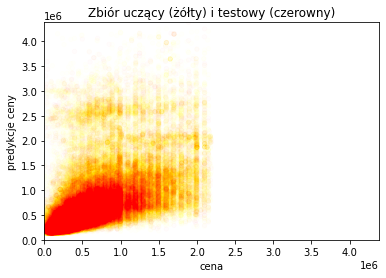

In [19]:
pred_no_outl.plot(kind='scatter', x='y', y='pred', alpha=.01, xlim=lim, ylim=lim,
    c=pred_no_outl['test'].map({0: 'yellow', 1: 'red'}), 
    title="Zbiór uczący (żółty) i testowy (czerowny)", ylabel='predykcje ceny', xlabel='cena');


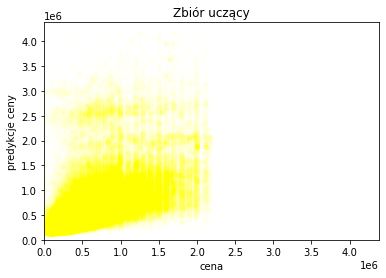

In [20]:
pred_no_outl.loc[pred['test'] == 0].plot(kind='scatter', x='y', y='pred', alpha=.01, xlim=lim, ylim=lim, c='yellow',
    title='Zbiór uczący', ylabel='predykcje ceny', xlabel='cena');

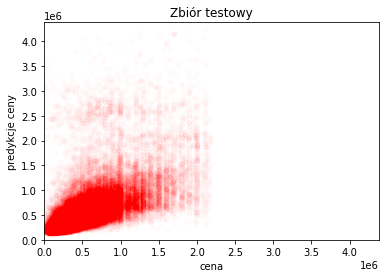

In [21]:
pred_no_outl.loc[pred['test'] == 1].plot(kind='scatter', x='y', y='pred', alpha=.01, c='red', xlim=lim, ylim=lim,
    title='Zbiór testowy', ylabel='predykcje ceny', xlabel='cena');

In [2]:
from sklearn.metrics import mean_squared_error
DataFrame({
    'MSE': [mean_squared_error(pred['y'], pred['pred'])]
}, index=['ocena'])

NameError: name 'DataFrame' is not defined